# Sparse Matrices in Julia

Julia has excellent built-in support for sparse matrices via the `SparseArrays` module. The primary type is `SparseMatrixCSC`, which, as the name implies, uses the **Compressed Sparse Column (CSC)** format we just learned about.

You can optionally specify the data type `Tv` for the non-zero values and the integer type `Ti` for the indices, e.g., `SparseMatrixCSC{Tv,Ti}`.

### Creating Sparse Matrices

You can create special sparse matrices with these functions:

| Sparse             | Dense           | Description                                    |
|:------------------ |:--------------- |:---------------------------------------------- |
| `spzeros(m,n)`     | `zeros(m,n)`    | An m-by-n sparse matrix with 0 non-zero entries. |
| `sparse(I, n, n)`  | `Matrix(I,n,n)` | An n-by-n sparse identity matrix.                |
| `Array(S)`         | `sparse(A)`     | Converts between dense (`Array`) and sparse (`SparseMatrixCSC`). |
| `sprand(m,n,d)`    | `rand(m,n)`     | An m-by-n random matrix (uniform) with density `d`. |
| `sprandn(m,n,d)`   | `randn(m,n)`    | An m-by-n random matrix (normal) with density `d`.  |

### The COO-to-CSC Constructor

The most common way to build a general sparse matrix is to first define the non-zeros in the **Coordinate (COO)** format and then pass them to the `sparse` function. Julia handles the conversion to the efficient CSC format automatically.

`A = sparse(rows, cols, vals, m, n)`

* `rows`: A vector of row indices for each non-zero.
* `cols`: A vector of column indices for each non-zero.
* `vals`: A vector of the non-zero values themselves.
* `m, n`: (Optional) The dimensions of the matrix.

**Note:** If multiple entries are given for the same `(row, col)` pair, `sparse` will **sum them up** during the conversion to CSC. This is an extremely useful feature.

### Inspecting Sparse Matrices

* `findnz(A)`: The inverse of the constructor. It returns the three COO vectors: `(rows, cols, vals)`.
* `nnz(A)`: Returns the number of non-zero entries stored in `A`.

## Example

Let's create the same 5x5 matrix from the previous section. We simply define the 10 non-zero entries in COO format and let `sparse` do the work.

In [1]:
# Load the required packages
using Plots, SparseArrays, LinearAlgebra

In [2]:
# 1. Define the matrix in COO format (List of Tuples)
# (Row, Col, Val)
# [1, 1, 5]
# [3, 1, -2]
# [4, 1, -4]
# [2, 2, 5]
# [1, 3, -3]
# [3, 3, -1]
# [1, 4, -2]
# [4, 4, -10]
# [1, 5, 7]
# [5, 5, 9]

# 2. Store these as three separate vectors
rows = [1,3,4,2,1,3,1,4,1,5]
cols = [1,1,1,2,3,3,4,4,5,5]
vals = [5,-2,-4,5,-3,-1,-2,-10,7,9]

# 3. Call the sparse constructor
# Julia converts (rows, cols, vals) -> CSC format automatically.
A = sparse(rows, cols, vals, 5, 5)

# Note: The output shows the size and the 10 "stored entries" (non-zeros).

5×5 SparseMatrixCSC{Int64, Int64} with 10 stored entries:
  5  ⋅  -3   -2  7
  ⋅  5   ⋅    ⋅  ⋅
 -2  ⋅  -1    ⋅  ⋅
 -4  ⋅   ⋅  -10  ⋅
  ⋅  ⋅   ⋅    ⋅  9

Julia's display method for sparse matrices is compact and only shows the non-zero values. If needed, we can always convert it back to a standard `Array` to see the full dense representation.

In [3]:
# Convert the SparseMatrixCSC into a dense Array
Array(A)

5×5 Matrix{Int64}:
  5  0  -3   -2  7
  0  5   0    0  0
 -2  0  -1    0  0
 -4  0   0  -10  0
  0  0   0    0  9

### Visualizing Sparsity: The `spy` Plot

For large matrices, printing the values is not helpful. What we really want to see is the *structure* of the non-zeros. This is called the *sparsity pattern*.

A **spy plot** is a standard tool for this. It's a 2D plot of the matrix where a dot is drawn at position $(i, j)$ if and only if the entry $A[i,j]$ is a non-zero. Julia provides this through the `spy` function.

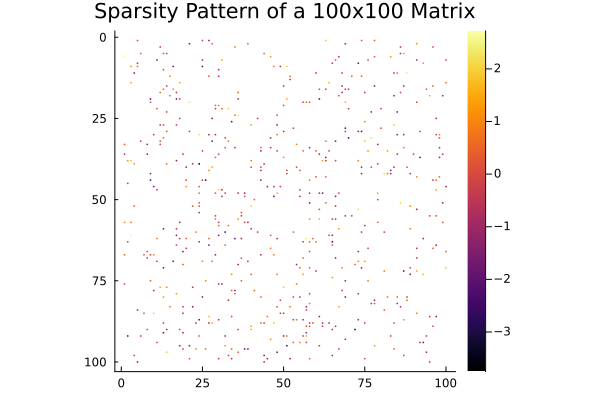

In [4]:
# Create a 100x100 random sparse matrix with 5% density
S = sprandn(100, 100, 0.05)

# Create a spy plot to visualize the sparsity pattern
# The y-axis is reversed to match standard matrix indexing (row 1 is at the top).
spy(S, title="Sparsity Pattern of a 100x100 Matrix")

## Incremental Construction: The Pitfall

The **most common mistake** when using sparse matrices is to build them *incrementally*. The CSC format is highly efficient for math, but it is terrible for adding new non-zeros one-by-one, as it requires rebuilding the internal arrays (`nzval`, `rowval`, `colptr`) with every insertion.

Let's test this. We'll write two functions to build a matrix with $10N$ non-zeros.

1.  **Test 1 (The BAD way):** Start with `spzeros` and add one new sparse matrix for each new element. This forces a complete CSC rebuild $10N$ times.
2.  **Test 2 (The GOOD way):** Build three simple COO vectors (`rows`, `cols`, `vals`) first. Then, call `sparse` **one time** at the end to perform a single, efficient conversion to CSC.

In [5]:
# Example 1: The SLOW way (rebuilding CSC on every addition)
# This is just for demonstration. Don't do this in real code!
function incremental_test_1(N)
    A = spzeros(N,N)
    for i = 1:10N
        # Each insertion operation creates a new SparseMatrixCSC, 
        # which is very expensive.
        i,j = rand(1:N, 2)
        A[i,j] = rand()
    end
    return A
end

incremental_test_1 (generic function with 1 method)

In [6]:
println("--- Test 1 (Slow Method) ---")
incremental_test_1(10); # Force compile before timing
for N in 1000 * 2 .^ (0:4)
    println("Timing for N=$N:")
    @time incremental_test_1(N)
end
# Note: The time appears to scale quadratically with N

--- Test 1 (Slow Method) ---
Timing for N=1000:
  0.002416 seconds (20.05 k allocations: 1.409 MiB)
Timing for N=2000:
  0.010490 seconds (40.05 k allocations: 2.179 MiB)
Timing for N=4000:
  0.034585 seconds (80.05 k allocations: 4.670 MiB)
Timing for N=8000:
  0.131651 seconds (160.06 k allocations: 9.820 MiB)
Timing for N=16000:
  0.549505 seconds (320.06 k allocations: 20.311 MiB, 0.89% gc time)


Now, let's look at the correct, efficient approach.

In [7]:
# Example 2: The FAST way (build COO lists, then convert once)
function incremental_test_2(N)
    # 1. Initialize empty COO lists (standard Julia Vectors)
    rows = Int64[]
    cols = Int64[]
    vals = Float64[]
    
    # 2. Build the lists. 'push!' is very fast.
    for i = 1:10N
        push!(rows, rand(1:N))
        push!(cols, rand(1:N))
        push!(vals, rand())
    end
    
    # 3. Perform ONE conversion from (COO) -> CSC
    return sparse(rows, cols, vals, N, N)
end

incremental_test_2 (generic function with 1 method)

In [8]:
println("\n--- Test 2 (Fast Method) ---")
incremental_test_2(10);   # Force compile before timing
for N in 1000 * 2 .^ (0:4)
    println("Timing for N=$N:")
    @time incremental_test_2(N)
end
# Note: This is orders of magnitude faster and scales close to linearly


--- Test 2 (Fast Method) ---
Timing for N=1000:
  0.000235 seconds (66 allocations: 1.285 MiB)
Timing for N=2000:
  0.000303 seconds (66 allocations: 1.612 MiB)
Timing for N=4000:
  0.001080 seconds (72 allocations: 3.693 MiB)
Timing for N=8000:
  0.002839 seconds (78 allocations: 8.107 MiB)
Timing for N=16000:
  0.006568 seconds (84 allocations: 17.221 MiB, 48.00% gc time)
